In [ ]:
#!/usr/bin/env python
# coding: utf-8

#### Import libraries

In [8]:
import time
import gower
import random
import pandas as pd
import numpy as np
from goodness import *
import seaborn as sns
from numpy import meshgrid
from numpy import arange
from numpy import hstack
from scipy import stats
#get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.metrics import r2_score
from sklearn.metrics import balanced_accuracy_score
from scipy.spatial.distance import cdist, pdist
from scipy.spatial.distance import _validate_vector
from scipy.stats import median_absolute_deviation
from sklearn.neighbors import LocalOutlierFactor
from pandas.errors import EmptyDataError
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
plt.style.use("seaborn-whitegrid")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif

#### Read data

In [2]:
# set the path as per your directory system, and download the dataset file from the data/repository
path = r'C:\Users\laboratorio\Documents\Suffian PhD Work\codes\datasets\Bank_Loan.csv'
bankloan = pd.read_csv(path)
del bankloan['Unnamed: 0']
del bankloan['age']
del bankloan['Experience']

#### Collecting Label-1 data points

In [3]:
data_lab1 = pd.DataFrame()
data_lab1 = bankloan[bankloan["Personal Loan"] == 1]
data_lab0 = bankloan[bankloan["Personal Loan"] == 0]
data_lab1 = data_lab1.drop(['Personal Loan'], axis=1)
len(data_lab1), len(data_lab0)

(3116, 4520)

#### importing ufce functionality

In [4]:
import ufce
from goodness import *
from ufce import UFCE
ufc = UFCE()

#### Mutual Information

In [5]:
Y = bankloan.loc[ : , bankloan.columns == 'Personal Loan'] 
X = bankloan.loc[ : , bankloan.columns != 'Personal Loan']
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
discrete_features = X.dtypes == int

mi_scores = ufc.make_mi_scores(X, Y, discrete_features)
mi_scores  # show a few features with their MI scores

#get top mutual information sharing pair of feature
features = ['Income', 'Family', 'CCAvg', 'Education', 'Mortgage',
       'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard']
cat_f = ['SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard']
F = ufc.get_top_MI_features(X, features)
F[:5]

C:\Users\laboratorio\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[['CCAvg', 'Income'],
 ['CDAccount', 'CCAvg'],
 ['CDAccount', 'Income'],
 ['Mortgage', 'CCAvg'],
 ['CDAccount', 'Mortgage']]

#### Train-test splits with a random state that provides the best distribution fit of data

In [6]:
from scipy import stats
from sklearn.model_selection import train_test_split
n_features = X.shape[1]
n_tries = 5
result = []
for random_state in range(n_tries):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=random_state)
    distances = list(map(lambda i : stats.ks_2samp(X_train.iloc[:,i],X_test.iloc[:,i]).statistic,range(n_features)))
    result.append((random_state,max(distances)))
result.sort(key = lambda x : x[1])

# from result, random state is important to train the model on the best split
idx = 0
random_state = result[idx][0]  
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=random_state)
X_test.to_csv(path + 'X_test' + '.csv', index=False)
X_train.to_csv(path + 'X_train' + '.csv', index=False)

In [9]:
# Training ML models
lr = LogisticRegression(max_iter=1000)
model = MLPClassifier(max_iter=1000)
model.fit(X_train,y_train.values.ravel())
lr.fit(X_train,y_train.values.ravel())
print("LR R2 score",r2_score(y_test.values.ravel(),lr.predict(X_test)))
print("LR accuracy",accuracy_score(y_test.values.ravel(), lr.predict(X_test)))

LR R2 score 0.853268119858659
LR accuracy 0.9642077695329551


In [ ]:
# 10-fold cross validation<br>
from sklearn.model_selection import cross_val_score<br>
lr = LogisticRegression(max_iter=1000)<br>
lr.fit(X_train, y_train)<br>
scores = cross_val_score(lr, X=X_train, y=y_train, cv=10, n_jobs=1)<br>
print('Cross Validation accuracy scores: %s' % scores)<br>
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
mlp = MLPClassifier(max_iter=1000)<br>
mlp.fit(X_train, y_train)<br>
scores = cross_val_score(mlp, X=X_train, y=y_train, cv=10, n_jobs=1)<br>
print('Cross Validation accuracy scores: %s' % scores)<br>
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

#### user feedback constraints

In [10]:
uf = {'Income':70, 'CCAvg':3.0, 'Family': 3, 'Education':3, 'Mortgage':100, 'CDAccount':1,'Online':1, 'SecuritiesAccount':1, 'CreditCard':1}
catf = ['CDAccount','Online', 'SecuritiesAccount', 'CreditCard']
numf = ['Income', 'CCAvg', 'Family', 'Education', 'Mortgage']
f2change = ['Income', 'CCAvg', 'Mortgage', 'CDAccount', 'Online']
desired_outcome = 1.0
k = 1

#### Nearest Neighbours

In [11]:
#nearest neighbor
nn, idx = ufc.NNkdtree(data_lab1, X_test[:1], 100)

In [ ]:
cfs = ufc.get_cfs_validated(nn, lr, 1)
# len(cfs)

In [ ]:
#features to change
ufc.feat2change(X_test[:1], nn[0:1])

#### Gen. CFs with UFCE1

In [12]:
oneF_cfdf = pd.DataFrame()
onetest_cfdf = pd.DataFrame()
found_indexes = []
start = time.time()
for t in range(len(X_test[:1])):
    n = 0
    nn, idx = ufc.NNkdtree(data_lab1, X_test[t:t+1], 100) #increase radius size as per the dataset
    #cfs = get_cfs_validated(nn, mlp, desired_outcome) # in case if cfs are not avalable then use nn
    #print(len(cfs), len(nn))
    if nn.empty != True:
        #f2change = feat2change(X_test[t:t+1], nn[:1])
        interval = ufc.make_intervals(nn, n, uf, f2change, X_test[t:t+1], catf, numf) # also use cfs instead of nn
        #print(t, interval)
        cc= ufc.one_feature_binsearch(X_test[t:t+1], catf, numf, interval, lr, desired_outcome, k)
        while cc.empty == True:
            n = n+1
            interval = ufc.make_intervals(nn, n, uf, f2change, X_test[t:t+1], catf, numf) #also use cfs instead of nn
            cc = ufc.one_feature_binsearch(X_test[t:t+1], catf, numf, interval, lr, desired_outcome, k)
            if n >= 10:
                #print('for test',t,'cf not found')
                break
        if cc.empty != True:
            found_indexes.append(t)
            #oneF_cfdf = pd.concat([oneF_cfdf, nn[n:n+1]], ignore_index=True, axis=0) #to open for nn point as cf
            #print('test',t, Xtest[t:t+1].values,'cf', cc[:1].values)
            oneF_cfdf = pd.concat([oneF_cfdf, cc[:1]], ignore_index=True, axis=0)
    #onetest_cfdf = pd.concat([onetest_cfdf, test[:1]], ignore_index=True, axis=0)
    #oneF_cfdf.to_csv(r'C:\Users\laboratorio\Desktop\demo\updateApproach\results\plots\ufc-dice\OneF_mlp'+'.csv')
end = time.time()
onetime = end - start
print('ufce1 time', onetime)

ufce1 time 1.8772971630096436


#### Gen. CFs with UFCE2

In [13]:
#running th eexperiment for mutliple test instances (at-least 50 for comparison)
start = time.time()
desired_outcome = 1.0
k = 1
n = 0
perturb_step = {}
twoF_cfdf = pd.DataFrame()
protectedf = [] # take empty
for t in range(len(X_test[:1])):
    n=0
    nn, idx = ufc.NNkdtree(data_lab1, X_test[t:t+1], 100)
    #cfs = get_cfs_validated(nn, model, desired_outcome)
#     print(len(cfs), len(nn))
    #intervals = make_interval(cfs, 1, Xtest[t:t+1])
    if nn.empty != True:
        intervals = ufc.make_uf_nn_interval(uf, F[:5], nn, 5, X_test[t:t+1])
        cc2, cfsexp2 = ufc.two_feature_update_corr_reg_binsearch(X, X_test[t:t+1], protectedf, F[:5], catf, numf, intervals, features, perturb_step, lr, desired_outcome, k)
        while cc2.empty == True:
            n = n+1
            intervals = ufc.make_uf_nn_interval(uf, F[:5], nn, 5, X_test[t:t+1])
            cc2, cfsexp2 = ufc.two_feature_update_corr_reg_binsearch(X, X_test[t:t+1], protectedf, F[:5], catf, numf, intervals, features, perturb_step, lr, desired_outcome, k)
            if n >= 15:
                break
        if cc2.empty == True:
            cnn = nn[n:n+1].values
            twoF_cfdf = pd.concat([twoF_cfdf, nn[n:n+1]], ignore_index=True, axis=0)
        else:
            cnn = []
        #print(intervals)
        #print('test',t, Xtest[t:t+1].values,'cf', cc2[:1].values, cnn)
        twoF_cfdf = pd.concat([twoF_cfdf, cc2[:1]], ignore_index=True, axis=0)
        #twoF_cfdf.to_csv(r'C:\Users\laboratorio\Desktop\demo\updateApproach\results\plots\ufc-dice\twoF'+'.csv')
end = time.time()
twotime = end-start
print('ufce2 time:', twotime)

ufce2 time: 0.6756606101989746


#### GEn. CFs with UFCE3

In [14]:
#running th eexperiment for mutliple test instances (at-least 50 for comparison)
start = time.time()
desired_outcome = 1.0
k = 1
perturb_step = {}
n = 0
protectedf = [] # take empty
feature_pairs = F[:5]
threeF_cfdf = pd.DataFrame()
for t in range(len(X_test[:1])):
    n=0
    nn, idx = ufc.NNkdtree(data_lab1, X_test[t:t+1], 100)
    #print(len(nn))
    #cfs = get_cfs_validated(nn, model)
    #intervals = make_interval(cfs, 1, Xtest[t:t+1])
    if nn.empty != True:
        intervals = ufc.make_uf_nn_interval(uf, feature_pairs, nn, 5, X_test[t:t+1]) # cfs instead nn
        cc2, cfsexp2 = ufc.three_feature_update_corr_reg_binsearch(X, X_test[t:t+1], protectedf, feature_pairs, catf, numf, intervals, features, perturb_step, lr, desired_outcome, k)
        while cc2.empty == True:
            n = n+1
            intervals = ufc.make_uf_nn_interval(uf, feature_pairs, nn, 5, X_test[t:t+1])
            cc2, cfsexp2 = ufc.three_feature_update_corr_reg_binsearch(X, X_test[t:t+1], protectedf, feature_pairs, catf, numf, intervals, features, perturb_step, lr, desired_outcome, k)
            if n >= 10:
                break
        if cc2.empty == True:
            cnn = nn[n:n+1].values
            threeF_cfdf = pd.concat([threeF_cfdf, nn[n:n+1]], ignore_index=True, axis=0)
        else:
            cnn = []
        #print(intervals)
        #print('test',t, Xtest[t:t+1].values,'cf', cc2[:1].values, cnn)
        threeF_cfdf = pd.concat([threeF_cfdf, cc2[:1]], ignore_index=True, axis=0)
        #threeF_cfdf.to_csv(r'C:\Users\laboratorio\Desktop\demo\updateApproach\results\plots\ufc-dice\threeF_mlp'+'.csv')
end = time.time()
threetime = end-start
print('ufce3 time:', threetime)

ufce3 time: 40.80633354187012


#### Gen. CFs with DiCE

In [ ]:
# pip install dice_ml

In [15]:
import time
import dice_ml
from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split
start = time.time()
d = dice_ml.Data(dataframe=bankloan, continuous_features=numf, outcome_name= 'Personal Loan')
m = dice_ml.Model(model=lr, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")
#path = r'C:\Users\laboratorio\Desktop\demo\updateApproach\results\DiCE\'
dice_cfs = pd.DataFrame()
for x in range(1):
    e1 = exp.generate_counterfactuals(X_test[x:x+1], total_CFs=1, desired_class="opposite", features_to_vary= features)
    #e1.cf_examples_list[0].final_cfs_df[0:1].to_csv(path + '' + str(x) + '' + '.csv', index=False)
    cf = e1.cf_examples_list[0].final_cfs_df[0:1]
    dice_cfs = pd.concat([dice_cfs, cf], ignore_index = True, axis = 0)
#dice_cfs.to_csv(r'C:\Users\laboratorio\Desktop\demo\updateApproach\results\plots\ufc-dice\DiCE_mlp'+'.csv')
end = time.time()
dicetime = end-start
print('dice time:', dicetime)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]

dice time: 0.6440691947937012


#### Gen. CFs with AR

In [ ]:
#pip install actionable-recourse

In [16]:
import recourse as rs
start = time.time()
A = rs.ActionSet(X)
from IPython.core.display import display, HTML
X = bankloan.loc[ : , bankloan.columns != 'Personal Loan']
y = bankloan['Personal Loan']
# train a classifier
clf = LogisticRegression(max_iter = 500)
clf.fit(X, y)
A.set_alignment(clf)
ar_cfs = pd.DataFrame()
for x in range(2):
    fs = rs.Flipset(X_test[x:x+1].values, action_set = A, clf = clf)
    fs.populate(enumeration_type='distinct_subsets', total_items = 1) #'mutually_exclusive'
    f_list = numf #['Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
    #features that need to be changed and could flip the outcome bt fs
    feat2change = fs.df['features']
    values_2change = fs.df['x_new']
    changed_instance = X_test[x:x+1].copy()
    d = {0:'Income', 1:'Family', 2:'CCAvg', 3:'Education', 4:'Mortgage', 5:'Securities Account', 6:'CD Account', 7:'Online', 8:'CreditCard'}
    for f, i in enumerate(feat2change):
        changed_instance[i] = values_2change[f]
    ar_cfs = pd.concat([ar_cfs, changed_instance], ignore_index = True, axis = 0)
end = time.time()
artime = end-start
print('AR time:', artime)

C:\Users\laboratorio\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


obtained 1 items in 0.0 seconds
obtained 1 items in 0.0 seconds
AR time: 1.8062639236450195


#### Gen. CFs with CEM

CEM results are available on google.colab notebook. access from the specific path.

In [17]:
def diverse_CFs(test, nn_valid, uf, c_f):

#     test: test instance
#     nn_valid: valid nearest neighbors (df)<br>
#     uf: user feedback (dict)<br>
#     c_f: changeable features (dict)<br>
    
    cfs = pd.DataFrame()
    #for f in changeable_f:<br>
    # print(test[c_f[0]].values[0], (test[c_f[0]].values + uf[c_f[0]])[0])<br>
    # nn_d = nn[nn[c_f[0]].between(test[c_f[0]].values[0], (test[c_f[0]].values + uf[c_f[0]])[0])]<br>
    # nn_d = nn_d[nn_d[c_f[1]].between(test[c_f[1]].values[0], (test[c_f[1]].values + uf[c_f[1]])[0])]<br>
    # nn_d = nn_d[nn_d[c_f[2]].between(test[c_f[2]].values[0], (test[c_f[2]].values + uf[c_f[2]])[0])]<br>
    # nn_d = nn_d[nn_d[c_f[3]].between(test[c_f[3]].values[0], (test[c_f[3]].values + uf[c_f[3]])[0])]<br>
    cfs = nn_valid
    for i in range(len(c_f)):
        cfs = cfs[cfs[c_f[i]].between(test[c_f[i]].values[0], (test[c_f[i]].values + uf[c_f[i]])[0])]
    return cfs

#### Evaluation metrics

#### Proximity

joint-proximty

C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)


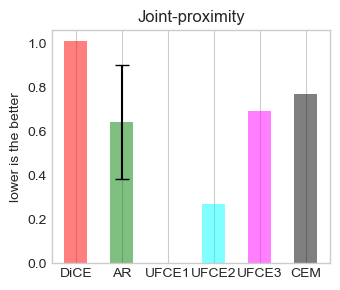

In [18]:
one_e2j = []
for x in range(len(oneF_cfdf)):
    one_e2j.append(ufc.distance_e2j(X_test[x:x+1], oneF_cfdf[x:x+1], numf, catf, ratio_cont=None, agg=None))
two_e2j = []
for x in range(len(twoF_cfdf)):
    two_e2j.append(ufc.distance_e2j(X_test[x:x+1], twoF_cfdf[x:x+1], numf, catf, ratio_cont=None, agg=None))
three_e2j = []
for x in range(len(threeF_cfdf)):
    three_e2j.append(ufc.distance_e2j(X_test[x:x+1], threeF_cfdf[x:x+1], numf, catf, ratio_cont=None, agg=None))
del dice_cfs['Personal Loan']
dice_e2j = []
for x in range(len(dice_cfs)):
    dice_e2j.append(ufc.distance_e2j(X_test[x:x+1], dice_cfs[x:x+1], numf, catf, ratio_cont=None, agg=None))
ar_e2j = []
for x in range(len(ar_cfs)):
    ar_e2j.append(ufc.distance_e2j(X_test[x:x+1], ar_cfs[x:x+1], numf, catf, ratio_cont=None, agg=None))
one = np.mean(one_e2j)
two = np.mean(two_e2j)
three = np.mean(three_e2j)
dice = np.mean(dice_e2j)
ar = np.mean(ar_e2j)
cem = three #take value from colab
dice_std = np.std(dice_e2j, ddof=1) / np.sqrt(np.size(dice_e2j))
ar_std = np.std(ar_e2j, ddof=1) / np.sqrt(np.size(ar_e2j))
one_std = np.std(one_e2j, ddof=1) / np.sqrt(np.size(one_e2j))
two_std = np.std(two_e2j, ddof=1) / np.sqrt(np.size(two_e2j))
three_std = np.std(two_e2j, ddof=1) / np.sqrt(np.size(two_e2j))
cem_std = three_std
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [dice/100, ar/100, one/100, two/100, three/100, 77/100]
error = [dice_std/100, ar_std/100, one_std/100, two_std/100, three_std/100, three_std/100]
# Build the plot
ufc.barplot(methods, CTEs, x_pos, error, 'Joint-proximity', 'lower is the better', False)

proximty-categorical

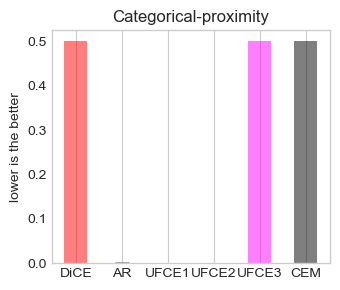

In [19]:
one_e2j = []
for x in range(len(oneF_cfdf)):
    one_e2j.append(ufc.categorical_distance(X_test[x:x+1], oneF_cfdf[x:x+1], catf, metric='jaccard', agg=None))
two_e2j = []
for x in range(len(twoF_cfdf)):
    two_e2j.append(ufc.categorical_distance(X_test[x:x+1], twoF_cfdf[x:x+1], catf, metric='jaccard', agg=None))
three_e2j = []
for x in range(len(threeF_cfdf)):
    three_e2j.append(ufc.categorical_distance(X_test[x:x+1], threeF_cfdf[x:x+1], catf, metric='jaccard', agg=None))
dice_e2j = []
for x in range(len(dice_cfs)):
    dice_e2j.append(ufc.categorical_distance(X_test[x:x+1], dice_cfs[x:x+1], catf, metric='jaccard', agg=None))
ar_e2j = []
for x in range(len(ar_cfs)):
    ar_e2j.append(ufc.categorical_distance(X_test[x:x+1], ar_cfs[x:x+1], catf, metric='jaccard', agg=None))
## Plots
one = np.mean(one_e2j)
two = np.mean(two_e2j)
three = np.mean(three_e2j)
dice = np.mean(dice_e2j)
ar = np.mean(ar_e2j)
cem = three # take from colab
dice_std = np.std(dice_e2j, ddof=1) / np.sqrt(np.size(dice_e2j))
ar_std = np.std(ar_e2j, ddof=1) / np.sqrt(np.size(ar_e2j))
one_std = np.std(one_e2j, ddof=1) / np.sqrt(np.size(one_e2j))
two_std = np.std(two_e2j, ddof=1) / np.sqrt(np.size(two_e2j))
three_std = np.std(two_e2j, ddof=1) / np.sqrt(np.size(two_e2j))
cem_std = three_std #need to take from colab
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [dice, ar, one, two, three, cem]
error = [dice_std, ar_std, one_std, two_std, three_std, cem_std]
# Build the plot
ufc.barplot(methods, CTEs, x_pos, error, 'Categorical-proximity', 'lower is the better', False)

proximty-numerical

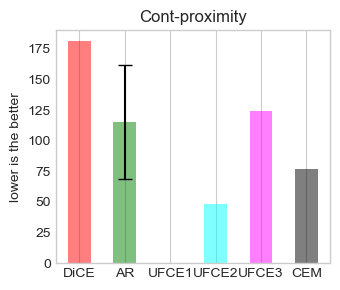

In [20]:
one_e2j = []
for x in range(len(oneF_cfdf)):
    one_e2j.append(ufc.continuous_distance(X_test[x:x+1], oneF_cfdf[x:x+1], numf, metric='euclidean', agg=None))
two_e2j = []
for x in range(len(twoF_cfdf)):
    two_e2j.append(ufc.continuous_distance(X_test[x:x+1], twoF_cfdf[x:x+1], numf, metric='euclidean', agg=None))
three_e2j = []
for x in range(len(threeF_cfdf)):
    three_e2j.append(ufc.continuous_distance(X_test[x:x+1], threeF_cfdf[x:x+1], numf, metric='euclidean', agg=None))
dice_e2j = []
for x in range(len(dice_cfs)):
    dice_e2j.append(ufc.continuous_distance(X_test[x:x+1], dice_cfs[x:x+1], numf, metric='euclidean', agg=None))
ar_e2j = []
for x in range(len(ar_cfs)):
    ar_e2j.append(ufc.continuous_distance(X_test[x:x+1], ar_cfs[x:x+1], numf, metric='euclidean', agg=None))
one = np.mean(one_e2j)
two = np.mean(two_e2j)
three = np.mean(three_e2j)
dice = np.mean(dice_e2j)
ar = np.mean(ar_e2j)
cem = three
dice_std = np.std(dice_e2j, ddof=1) / np.sqrt(np.size(dice_e2j))
ar_std = np.std(ar_e2j, ddof=1) / np.sqrt(np.size(ar_e2j))
one_std = np.std(one_e2j, ddof=1) / np.sqrt(np.size(one_e2j))
two_std = np.std(two_e2j, ddof=1) / np.sqrt(np.size(two_e2j))
three_std = np.std(two_e2j, ddof=1) / np.sqrt(np.size(two_e2j))
cem_std = three_std
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [dice, ar, one, two, three, 77]
error = [dice_std, ar_std, one_std, two_std, three_std, three_std]
# Build the plot
ufc.barplot(methods, CTEs, x_pos, error, 'Cont-proximity', 'lower is the better', False)

#### Sparsity

C:\Users\laboratorio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


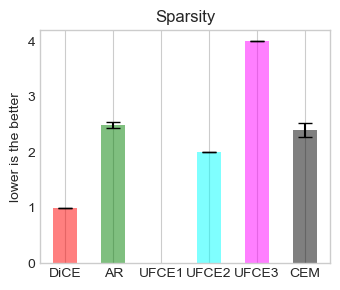

In [22]:
one_sparsity_d, one_val = ufc.sparsity_count(oneF_cfdf, len(oneF_cfdf), X_test, numf)
two_sparsity_d, two_val = ufc.sparsity_count(twoF_cfdf, len(twoF_cfdf), X_test,  numf)
three_sparsity_d, three_val = ufc.sparsity_count(threeF_cfdf, len(threeF_cfdf), X_test,  numf)
dice_sparsity_d, dice_val = ufc.sparsity_count(dice_cfs, len(dice_cfs), X_test,  numf)
ar_sparsity_d, ar_val = ufc.sparsity_count(ar_cfs, len(ar_cfs), X_test, numf)
dice = np.array(list(dice_sparsity_d.values())).mean()
ar = np.array(list(ar_sparsity_d.values())).mean()
one = np.array(list(one_sparsity_d.values())).mean()
two = np.array(list(two_sparsity_d.values())).mean()
three = np.array(list(three_sparsity_d.values())).mean()
cem = 2.4 # from colab
dice_std = np.array(list(dice_sparsity_d.values())).std()
ar_std = np.array(list(ar_sparsity_d.values())).std()
one_std = np.array(list(one_sparsity_d.values())).std()
two_std = np.array(list(two_sparsity_d.values())).std()
three_std = np.array(list(three_sparsity_d.values())).std()
cem_std = 1.1 #from colab
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [dice, ar, one, two, three, cem]
error = [dice_std/len(features), ar_std/len(features), one_std/len(features), two_std/len(features), three_std/len(features), cem_std/len(features)]
# Build the plot
ufc.barplot(methods, CTEs, x_pos, error, 'Sparsity', 'lower is the better', False)

#### Validity

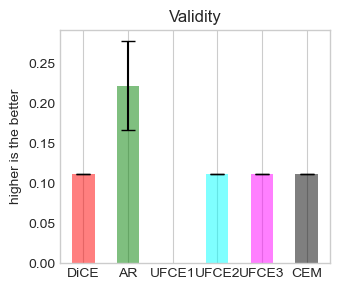

In [23]:
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [len(dice_cfs)/len(features), len(ar_cfs)/len(features), len(oneF_cfdf)/len(features), len(twoF_cfdf)/len(features), len(threeF_cfdf)/len(features), len(threeF_cfdf)/len(features)] #for cem, need to take values from Colab as it was only working on g.Colab
error = [dice_std/len(features), ar_std/len(features), one_std/len(features), two_std/len(features), three_std/len(features), three_std/len(features)]
ufc.barplot(methods, CTEs, x_pos, error, 'Validity', 'higher is the better', save=False)

#### Actionability

C:\Users\laboratorio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


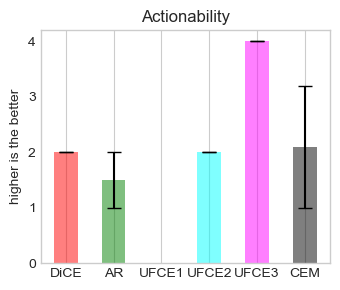

In [24]:
one_actionability_d, one_val = ufc.actionability(oneF_cfdf, len(oneF_cfdf), X_test, features, f2change)
two_actionability_d, two_val = ufc.actionability(twoF_cfdf, len(twoF_cfdf), X_test, features, f2change)
three_actionability_d, three_val = ufc.actionability(threeF_cfdf, len(threeF_cfdf), X_test, features, f2change)
dice_actionability_d, dice_val = ufc.actionability(dice_cfs, len(dice_cfs), X_test, features, f2change)
ar_actionability_d, ar_val = ufc.actionability(ar_cfs, len(ar_cfs), X_test, features, f2change)
dice = np.array(list(dice_actionability_d.values())).mean()
ar = np.array(list(ar_actionability_d.values())).mean()
one = np.array(list(one_actionability_d.values())).mean()
two = np.array(list(two_actionability_d.values())).mean()
three = np.array(list(three_actionability_d.values())).mean()
cem = 2.1
dice_std = np.array(list(dice_actionability_d.values())).std()
ar_std = np.array(list(ar_actionability_d.values())).std()
one_std = np.array(list(one_actionability_d.values())).std()
two_std = np.array(list(two_actionability_d.values())).std()
three_std = np.array(list(three_actionability_d.values())).std()
cem_std = 1.1
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs =  [dice, ar, one, two, three, cem]
error = [dice_std, ar_std, one_std, two_std, three_std, cem_std]
# Build the plot
ufc.barplot(methods, CTEs, x_pos, error, 'Actionability', 'higher is the better', save=False)

#### Plausibility

C:\Users\laboratorio\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\laboratorio\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


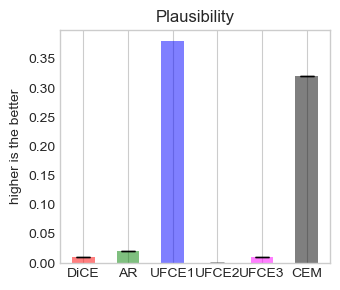

In [26]:
one_plausibility_d, one_val = ufc.implausibility(oneF_cfdf, X_test, X_train[:], len(oneF_cfdf))
two_plausibility_d, two_val = ufc.implausibility(twoF_cfdf, X_test, X_train[:], len(twoF_cfdf))
three_plausibility_d, three_val = ufc.implausibility(threeF_cfdf, X_test, X_train[:], len(threeF_cfdf))
# del dice_cfs['Personal Loan']
dice_plausibility_d, dice_val = ufc.implausibility(dice_cfs, X_test, X_train[:], len(dice_cfs))
ar_plausibility_d, ar_val = ufc.implausibility(ar_cfs, X_test, X_train[:], len(ar_cfs))
dice = np.array(list(dice_plausibility_d.values())).mean()
ar = np.array(list(ar_plausibility_d.values())).mean()
one = np.array(list(one_plausibility_d.values())).mean()
two = np.array(list(two_plausibility_d.values())).mean()
three = np.array(list(three_plausibility_d.values())).mean()
cem = 3
dice_std = np.array(list(dice_plausibility_d.values())).std()
ar_std = np.array(list(ar_plausibility_d.values())).std()
one_std = np.array(list(one_plausibility_d.values())).std()
two_std = np.array(list(two_plausibility_d.values())).std()
three_std = np.array(list(three_plausibility_d.values())).std()
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [dice_val/100, ar_val/100, 38/100, two_val/100, three_val/100, 32/100]
error = [dice_std/100, ar_std/100, one_std/100, two_std/100, three_std/100, three_std/100]
ufc.barplot(methods, CTEs, x_pos, error, 'Plausibility', 'higher is the better', save=False)

#### Feasibility

In [29]:
from sklearn.preprocessing import StandardScaler

In [27]:
def Feasibility(testfile, cffile, trainfile, features, variable_features, model, desired_outcome, label, dice=False):
    #cflist = pd.read_csv(path + cffile)
    cflist = cffile
    if dice==True:
        del cflist[label] #only for dice
#     X_test = pd.read_csv(path + testfile)
#     X_train = pd.read_csv(path + trainfile)
    scaler = StandardScaler() #check verify the scaler
    scaler = scaler.fit(X_train[:500])
    #del cflist['Unnamed: 0']
    feasible = 0
    for c in range(len(cflist)):
        valid = model.predict(cflist[c:c+1].values)
        if valid == desired_outcome:
            act = ufc.nbr_actionable_cfn(X_test[c:c+1], cflist[c:c+1], features, variable_features)
            ratio = 1 - act/len(features)
            if ratio > 0.5:
                plaus = int(ufc.lofn(X_test[c:c + 1], cflist[c:c + 1], X_train[:500], scaler))
                if plaus:
                    feasible += 1                
    if feasible != 0:
        feas_result = feasible / len(cflist)
    else:
        feas_result = feasible
    return feas_result

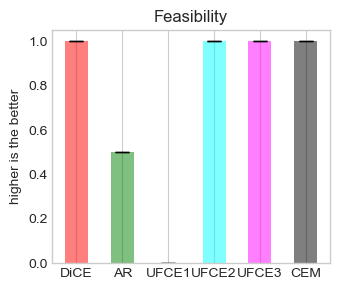

In [30]:
#feasibility
dice_f = Feasibility(X_test, dice_cfs, X_train, features, f2change, lr, desired_outcome, label='Personal Loan', dice=False)
ar_f = Feasibility(X_test, ar_cfs, X_train, features, f2change, lr, desired_outcome, label='Personal Loan', dice=False)       
one_f = Feasibility(X_test, oneF_cfdf, X_train, features, f2change, lr, desired_outcome, label='Personal Loan', dice=False)
two_f = Feasibility(X_test, twoF_cfdf, X_train, features, f2change, lr, desired_outcome, label='Personal Loan', dice=False)       
three_f = Feasibility(X_test, threeF_cfdf, X_train, features, f2change, lr, desired_outcome, label='Personal Loan', dice=False) 
methods = ['DiCE','AR', 'UFCE1', 'UFCE2', 'UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [dice_f, ar_f, one_f, two_f, three_f, three_f]
error = [0., 0., 0., 0., 0., 0.]
# # Build the plot
ufc.barplot(methods, CTEs, x_pos, error, 'Feasibility', 'higher is the better', False)

#### Diversity

In [31]:
def count_diversityn(cf_list, features, test, nbr_features, continuous_features):
    nbr_cf = cf_list.shape[0]
    nbr_changes = 0
    for i in range(nbr_cf):
            for k in features:
                #print(cf_list[i:i+1][k].values, test[k].values)
                if cf_list[i:i+1][k].values != test[k].values:
                    nbr_changes += 1 if k in continuous_features else 0.5
    return nbr_changes / (nbr_cf * nbr_features)

In [ ]:

# to compute self-cfs diversity by calling diversity_count()
# and to compute diversity of each cf with test by calling diversity_countn()


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


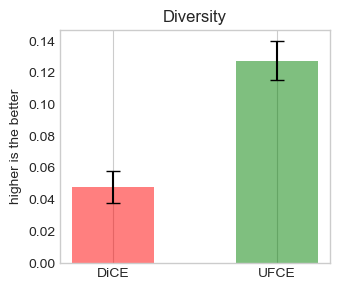

In [32]:
import pandas as pd
from goodness import *
import dice_ml
from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split
nbr_features = 9
countufce = dict()
for t in range(5):
    nn, idx = ufc.NNkdtree(data_lab1, X_test[t:t+1], 100)
    cfs = ufc.diverse_CFs(X_test[t:t+1], nn, uf, f2change)
    if cfs.shape[0] >= 10:
        countufce[t] = ufc.count_diversity(cfs[:10], features, nbr_features, numf) #use Xtest if diversityn
    elif cfs.shape[0] != 0 and cfs.shape[0] < 10:
        countufce[t] = ufc.count_diversity(cfs, features, nbr_features, numf)
    else:
        countufce[t] = 0.1
# print(countufce)
countdice = dict()
d = dice_ml.Data(dataframe=bankloan, continuous_features=numf, outcome_name= 'Personal Loan')
m = dice_ml.Model(model=lr, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")
dice_cfs = pd.DataFrame()
for x in range(5):
    e1 = exp.generate_counterfactuals(X_test[x:x+1], total_CFs=5, desired_class="opposite", features_to_vary= f2change)
    #e1.cf_examples_list[0].final_cfs_df[0:1].to_csv(path + '' + str(x) + '' + '.csv', index=False)
    cf = e1.cf_examples_list[0].final_cfs_df[0:5]
    if cf.empty != True:
        countdice[x] = count_diversity(cf, features, nbr_features, numf)
    else:
        pass
    #dice_cfs = pd.concat([dice_cfs, cf], ignore_index = True, axis = 0)
    #dice_cfs.to_csv(r'C:\Users\laboratorio\Desktop\demo\updateApproach\results\DiCE'+'.csv')
dice = np.array(list(countdice.values())).mean()
ufce = np.array(list(countufce.values())).mean()
dicestd = np.array(list(countdice.values())).std()
ufcestd = np.array(list(countufce.values())).std()
methods = ['DiCE','UFCE']
x_pos = np.arange(len(methods))
CTEs = [dice, ufce]
error = [dicestd, ufcestd]
# # Build the plot
ufc.barplot(methods, CTEs, x_pos, error, 'Diversity', 'higher is the better', save=False)

#### Time

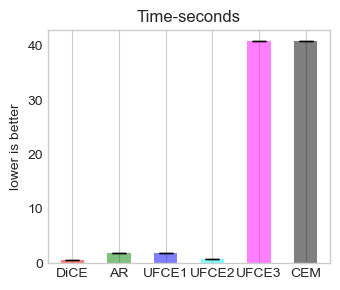

In [33]:
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [dicetime, artime, onetime, twotime, threetime, threetime]
error = [0., 0., 0., 0., 0., 0.] 
ufc.barplot(methods, CTEs, x_pos, error, 'Time-seconds', 'lower is better', save=True)

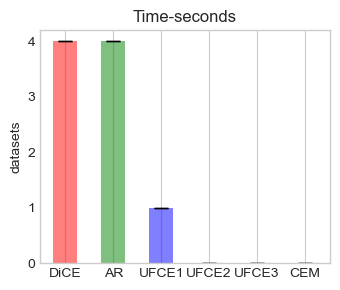

In [34]:
#Ranking of methods property-wise<br>
methods = ['DiCE','AR','UFCE1','UFCE2','UFCE3', 'CEM']
x_pos = np.arange(len(methods))
CTEs = [4, 4, 1, 0, 0, 0]
error = [0, 0, 0, 0, 0, 0]
# Build the plot<br>
ufc.barplot(methods, CTEs, x_pos, error, 'Time-seconds', 'datasets', save=True)

#### Generating natural language explanations

In [35]:
outcome_var = "The personal loan"
actual_class = 'denied'
desired_class = 'accepted'
test = pd.DataFrame(data=[[83, 4, 2, 3, 0, 0, 0, 1, 0]], columns =['Income', 'Family', 'CCAvg', 'Education', 'Mortgage',
       'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard'] )
cf1 = pd.DataFrame(data=[[132.34, 4, 2, 3, 103, 0, 0, 1, 0]], columns =['Income', 'Family', 'CCAvg', 'Education', 'Mortgage',
       'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard'] )
features, new_values, actual_values = ufc.features_to_explain(test, cf1)
ufc.generate_reason_explanation(outcome_var, desired_class, actual_class, features)
ufc.generate_suggestion_explanation(outcome_var, desired_class, actual_class, features, new_values, actual_values)

OUTCOME REASONS:
The personal loan is denied because values of Income and Mortgage are not enough.
Suggestion-Explanation:
The personal loan woulds be accepted if you change features Income and Mortgage to 132.34 and 103.


### User Feedback Analysis
TODO's
- If the contraints of user feedback are flexible and less-restrictive, then the diversity is observed.
- 5-folds test instances
- uf generation from Monte Carlo experiment/simulation 
- testing multiple methods for multiple datasets (gpu services)
- changing plots orientation
- qualitative use-case (analysis plots)
